# Cell Search Procedure Demo (Model 2)

Displays individual steps of cell search procedure in NR

Mark Disterhof, mardis@uni-bremen.de

In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
font = {'size'   : 16}
matplotlib.rc('font', **font)

from pyphysim.channels.fading import TdlChannel, TdlChannelProfile
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.modulators import OFDM

from nrphypy import signals, ssb, decode, threegpp_tdl_channels

## Simulation Parameters

In [2]:
# seed for reproducability
np.random.seed(0)

# Physical layer cell identity
N_ID1 = np.random.randint(336) # cell ID group {0,..,335}
N_ID2 = np.random.randint(3)   # cell ID sector {0,1,2}
N_ID_Cell = 3 * N_ID1 + N_ID2  # cell identity ID
NU = N_ID_Cell % 4
# OFDM Parameters 
mu = 0 # Numerology
CP_SIZE = 0
FFT_SIZE = 512 
Fd = 15
F = 10e9 # Hz
sh_spec = True
pa_spec = False
L_max = len(ssb.get_ssb_ids(ssb.get_ssb_candidate_idx(mu, F, sh_spec, pa_spec), mu, sh_spec))

n_db = 10

ch = 'TDL_A'

# k_ssb is a combination of higher layer parameters and is to be chosen for the sake of this simulation
# {0,1,2,...,23} for f < 6GHz expressed in multiples of 15kHz SCS
# {0,1,2,...,11} for f >= 6GHz expressed in multiples of 60kHz SCS
# See 38.211 7.4.3.1 
k_ssb = 11


In [3]:
def plot_grid(grid, title=''):
    fig, ax = plt.subplots(figsize=(18,8))
    ax.pcolormesh(np.array(range(len(grid[0]))) + 0.5, range(len(grid)), np.abs(grid), shading='auto')
    ax.set_title(title)
    ax.set_xlabel('OFDM Symbol')
    ax.set_ylabel('Subcarrier')
    plt.colorbar(ax.pcolor(np.abs(grid)), ax=ax)
    plt.savefig('./im/grid{}.png'.format(title), dpi=300)
    return fig

## Channel Model

In [4]:
bandwidth = 2**mu * 15e3 * FFT_SIZE
Ts = 1. / bandwidth  # Sampling interval

jakesObj = JakesSampleGenerator(Fd, Ts, L=10)

prof = TdlChannelProfile(*threegpp_tdl_channels.get_channel_profile(ch, ds_desired = 4*Ts ))
                         
channel = TdlChannel(jakesObj, prof)

RMS delay spread: 3.9185801523080075


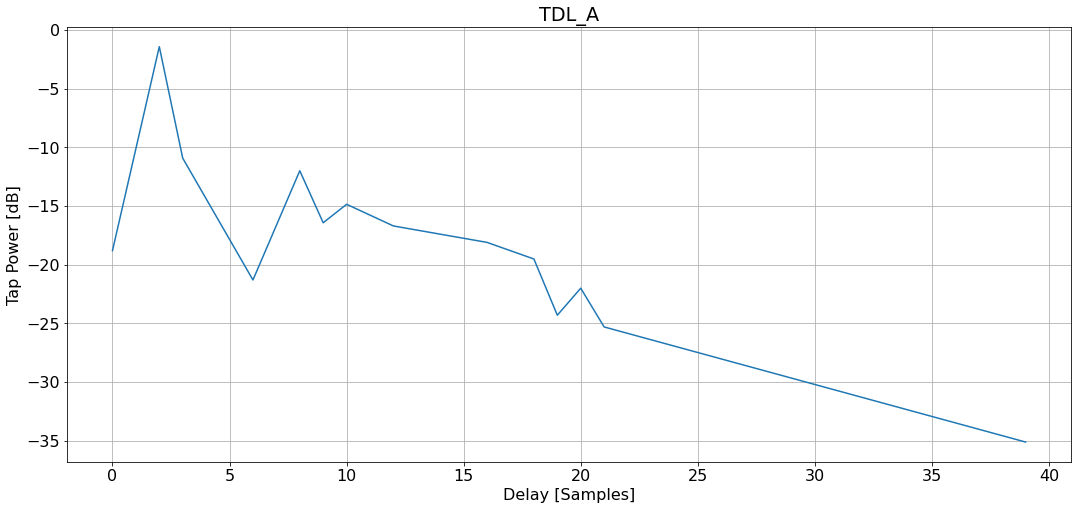

In [5]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title(ch,)
ax.set_ylabel('Tap Power [dB]')
ax.set_xlabel('Delay [Samples]')
ax.grid(True, which="both", ls="-")
ax.plot(channel.channel_profile.tap_delays, channel.channel_profile.tap_powers_dB)
print('RMS delay spread: {}'.format(channel.channel_profile.rms_delay_spread))
fig.savefig("./im/m2_ch.pdf", dpi=50)

## Synchronization procedure

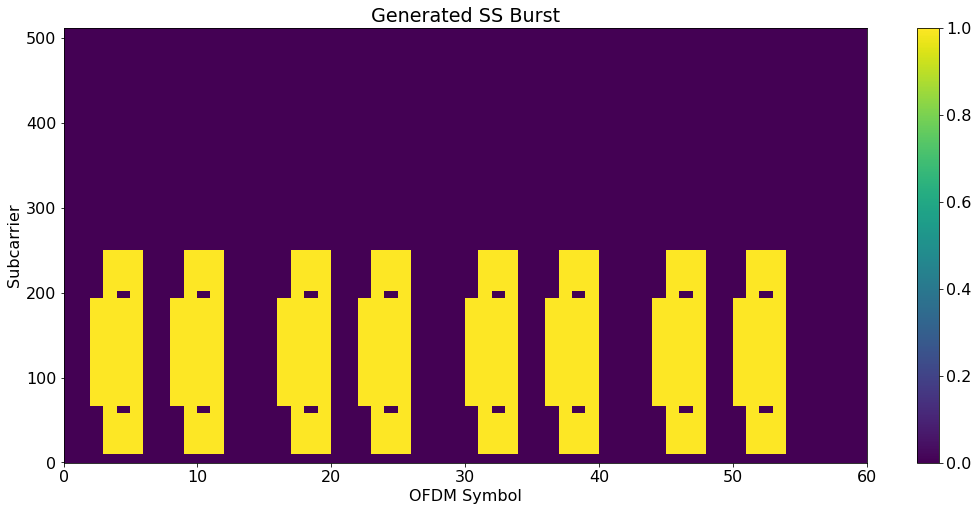

In [6]:
n_symb = 60
pbch_bits = np.random.randint(2,size=864)
rgrid = ssb.grid(FFT_SIZE, N_ID1, N_ID2, k_ssb, mu, F, sh_spec, pa_spec, pbch_bits)[:,:n_symb]

fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Generated SS Burst')
ax.set_xlabel('OFDM Symbol')
ax.set_ylabel('Subcarrier')
ax.pcolormesh(np.array(range(len(rgrid[0]))) + 0.5, range(len(rgrid)), np.abs(rgrid), shading='auto')
plt.colorbar(ax.pcolor(np.abs(rgrid)), ax=ax)

fig.savefig("./im/m2_rgrid.pdf", dpi=50)

## Modulation

In [7]:
ofdm_modem = OFDM(FFT_SIZE, CP_SIZE, num_used_subcarriers= len(rgrid))

s = ofdm_modem.modulate(rgrid.T.flatten())

## Transmission

In [8]:
rec = channel.corrupt_data(s).flatten()
n_lin = np.sqrt(np.mean(np.square(np.abs(s))))/np.sqrt(10**(n_db/10))
n = (np.random.normal(0,n_lin,len(rec)) + 1j* np.random.normal(0,n_lin,len(rec))) /np.sqrt(2)
rec += n

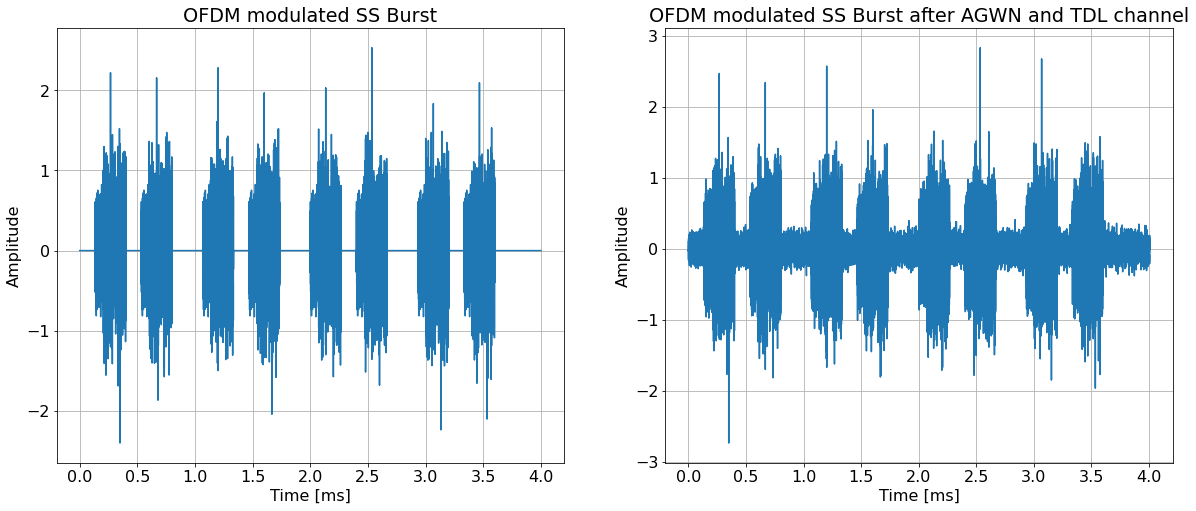

In [9]:
fig, [ax0,ax1] = plt.subplots(figsize=(20,8), ncols = 2)

ax0.set_title('OFDM modulated SS Burst')
ax0.set_xlabel('Time [ms]')
ax0.set_ylabel('Amplitude')
ax0.grid(True, which="both", ls="-")
_ = ax0.plot(1e3*Ts*np.arange(len(s)),np.real(s))

ax1.set_title('OFDM modulated SS Burst after AGWN and TDL channel')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Amplitude')
ax1.grid(True, which="both", ls="-")
_ = ax1.plot(1e3*Ts*np.arange(len(rec)),np.real(rec))

fig.savefig("./im/m2_sig_noise.pdf", dpi=50)

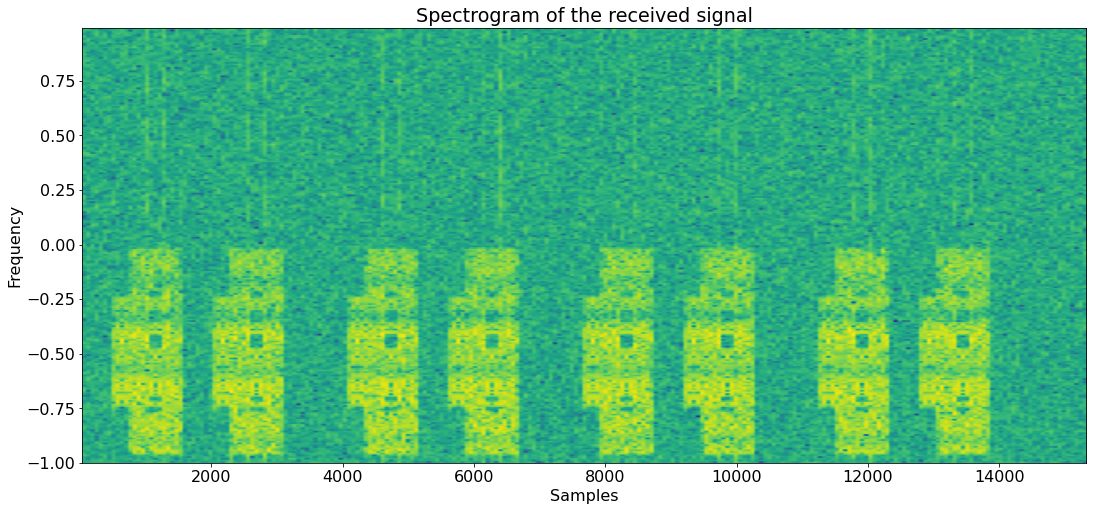

In [10]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Spectrogram of the received signal')
ax.set_xlabel('Samples')
ax.set_ylabel('Frequency')
_ = ax.specgram(rec)
fig.savefig("./im/m2_spec.pdf", dpi=50)

## Decode PSS for N_ID2

In [11]:
rec_no = rec[:(FFT_SIZE + CP_SIZE) * n_symb]
ssbs,nid2,samp, offs = decode.sync_pss(rec_no, FFT_SIZE, None)
rec_nid2 = int(np.mean(nid2)) # take mean of recorded nid2s as estimate
print('N_ID2:{}\nrecorded N_ID2:{}\n\nFound {} SSBs'.format(N_ID2, rec_nid2, len(ssbs)))

N_ID2:1
recorded N_ID2:1

Found 8 SSBs


## Decode SSS for complete N_ID_Cell

In [12]:
rec_sss = [decode.decode_sss(ssb.unmap_sss(ssb_i),rec_nid2) for ssb_i in ssbs]
rec_nid1 = int(np.mean(rec_sss))
rec_n_id_cell = 3 * rec_nid1 + rec_nid2

rec_nu = rec_n_id_cell % 4

print('N_ID1:{}\nN_ID_Cell:{}\nnu:{}\nrecN_ID1:{}\nrecN_ID_Cell:{}\nrecnu:{}'
      .format(N_ID1, N_ID_Cell, NU, rec_nid1, rec_n_id_cell, rec_nu))

N_ID1:172
N_ID_Cell:517
nu:1
recN_ID1:172
recN_ID_Cell:517
recnu:1


# Index detection

In [13]:
issbs = [decode.dmrs(ssb.unmap_pbch(ssbs[ind],rec_nu)[1], rec_n_id_cell, L_max) for ind in range(len(ssbs))]

#remove duplicate ssbs
uni_idx = np.unique(issbs, return_index=True)[1]
ssb_i = ssbs[uni_idx]
print('Found {} SSBs, removed {} of them.\nIndices: {} '.format(len(issbs), len(issbs)-len(ssb_i), issbs))

Found 8 SSBs, removed 0 of them.
Indices: [0, 1, 2, 3, 4, 5, 6, 7] 


# Compute PBCH BER

In [14]:
pbch_err = [(1-(np.sum(decode.decode_pbch(ssb.unmap_pbch(ssb_i[i], rec_nu)[0],L_max, rec_n_id_cell, issbs[uni_idx[i]]) 
               ==  pbch_bits)/len(pbch_bits)))*100. for i in range(len(ssb_i))]
_= [print('BER PBCH, SSB index {}: {}%'.format(i,pbch_err[i])) for i in range(len(ssb_i))]

BER PBCH, SSB index 0: 46.29629629629629%
BER PBCH, SSB index 1: 48.611111111111114%
BER PBCH, SSB index 2: 49.65277777777778%
BER PBCH, SSB index 3: 46.875%
BER PBCH, SSB index 4: 52.43055555555556%
BER PBCH, SSB index 5: 52.546296296296305%
BER PBCH, SSB index 6: 51.27314814814814%
BER PBCH, SSB index 7: 51.504629629629626%


# PBCH Equalization

In [15]:
deg = 10
pbch_eq = [ssb.unmap_pbch(
    decode.dmrs_eq(ssb_i[i],issbs[uni_idx[i]],rec_n_id_cell,L_max, deg), rec_n_id_cell%4)[0] for i in range(len(ssb_i))]

pbch_eq_err = [(1-(np.sum(decode.decode_pbch(pbch_eq[i],L_max, rec_n_id_cell, issbs[uni_idx[i]]) 
               ==  pbch_bits)/len(pbch_bits)))*100. for i in range(len(pbch_eq))]

_= [print('BER Equalized PBCH, SSB index {}: {}%'.format(issbs[uni_idx[i]],
                                                         pbch_eq_err[i])) for i in range(len(pbch_eq))]

BER Equalized PBCH, SSB index 0: 12.962962962962965%
BER Equalized PBCH, SSB index 1: 11.22685185185185%
BER Equalized PBCH, SSB index 2: 14.236111111111116%
BER Equalized PBCH, SSB index 3: 13.07870370370371%
BER Equalized PBCH, SSB index 4: 13.310185185185187%
BER Equalized PBCH, SSB index 5: 11.92129629629629%
BER Equalized PBCH, SSB index 6: 10.879629629629628%
BER Equalized PBCH, SSB index 7: 12.731481481481477%


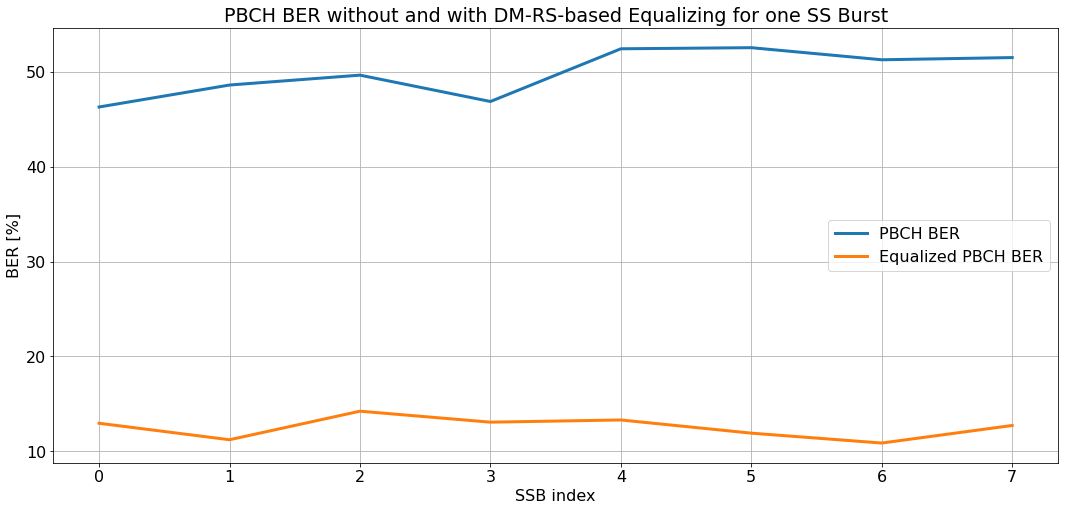

In [16]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('PBCH BER without and with DM-RS-based Equalizing for one SS Burst')
ax.set_xlabel('SSB index')
ax.set_ylabel('BER [%]')
ax.grid(True, which="both", ls="-")
ln = ax.plot(range(len(pbch_err)),pbch_err, range(len(pbch_err)), pbch_eq_err, linewidth=3)
ln[0].set_label('PBCH BER')
ln[1].set_label('Equalized PBCH BER')
_ = ax.legend()

fig.savefig("./im/m2_ber.pdf", dpi=50)

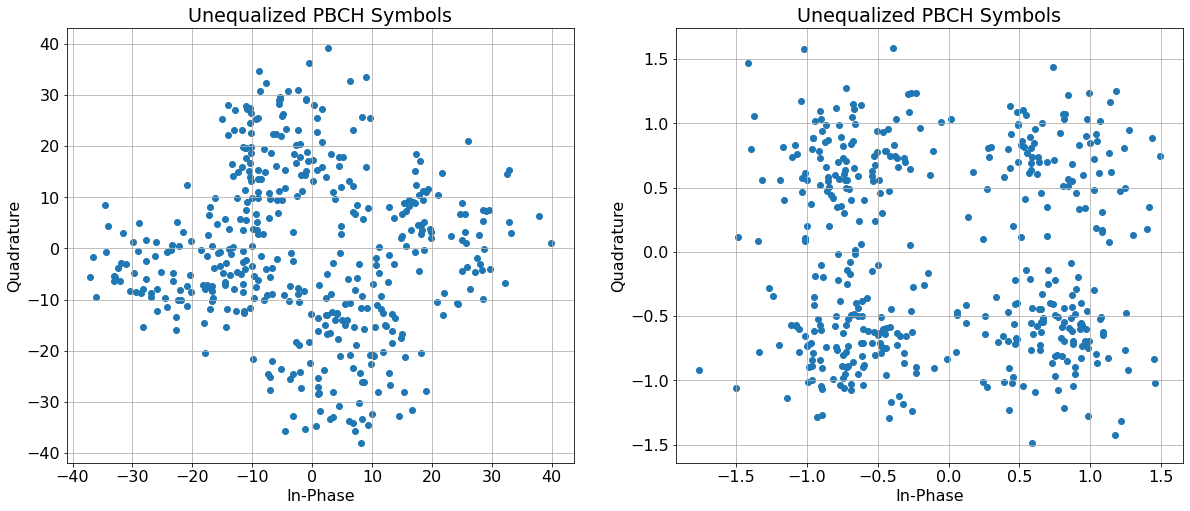

In [17]:
pbch = ssb.unmap_pbch(ssb_i[0], rec_n_id_cell%4)[0]
pbcheq = ssb.unmap_pbch(
        decode.dmrs_eq(ssb_i[0],0,rec_n_id_cell,L_max, deg)
        , rec_n_id_cell%4)[0]
deg = 12

fig, [ax0,ax1] = plt.subplots(figsize=(20,8), ncols = 2)

ax0.set_title('Unequalized PBCH Symbols')
ax0.set_xlabel('In-Phase')
ax0.set_ylabel('Quadrature')
ax0.grid(True, which="both", ls="-")
_ = ax0.scatter(pbch.real,pbch.imag)

ax1.set_title('Unequalized PBCH Symbols')
ax1.set_xlabel('In-Phase')
ax1.set_ylabel('Quadrature')
ax1.grid(True, which="both", ls="-")
_ = ax1.scatter(pbcheq.real,pbcheq.imag)

fig.savefig("./im/m2_eq.pdf", dpi=50)